In [30]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.special import factorial, gamma
from scipy import signal
import matplotlib.pyplot as plt
import warnings

In [31]:
def FDE_PI12_PC(alpha, f_fun, t0, T, y0, h, param=None, mu=0, mu_tol=1.0e-6):

    # Check order of the FDE
    alpha = np.array(alpha).flatten()
    if any(alpha <= 0):
        i_alpha_neg = np.where(alpha <= 0)[0][0]
        raise ValueError(f'The orders ALPHA of the FDEs must be all positive. The value ALPHA({i_alpha_neg}) = {alpha[i_alpha_neg]:.6f} cannot be accepted.')

    # Check the step-size of the method
    if h <= 0:
        raise ValueError(f'The step-size H for the method must be positive. The value H = {h:.6e} cannot be accepted.')

    # Check compatibility size of the problem with number of fractional orders
    alpha_length = len(alpha)
    problem_size = y0.shape[0]
    if alpha_length > 1:
        if problem_size != alpha_length:
            raise ValueError(f'Size {problem_size} of the problem as obtained from initial conditions not compatible with the number {alpha_length} of fractional orders for multi-order systems.')
    else:
        alpha = alpha * np.ones(problem_size)
        alpha_length = problem_size

    # Storage of initial conditions
    ic = {'t0': t0, 'y0': y0, 'm_alpha': np.ceil(alpha).astype(int)}
    ic['m_alpha_factorial'] = np.array([factorial(j) for i in range(alpha_length) for j in range(ic['m_alpha'][i])]).reshape(alpha_length, -1)

    # Storage of information on the problem
    Probl = {
        'ic': ic,
        'f_fun': f_fun,
        'problem_size': problem_size,
        'param': param,
        'alpha': alpha,
        'alpha_length': alpha_length
    }

    # Check number of initial conditions
    if y0.shape[1] < max(ic['m_alpha']):
        raise ValueError(f'A not sufficient number of assigned initial conditions. Order ALPHA = {max(alpha):.6f} requires {max(ic["m_alpha"])} initial conditions.')

    # Check compatibility size of the problem with size of the vector field
    f_temp = f_vectorfield(t0, y0[:, 0], Probl)
    if Probl['problem_size'] != f_temp.shape[0]:
        raise ValueError(f'Size {Probl["problem_size"]} of the problem as obtained from initial conditions not compatible with the size {f_temp.shape[0]} of the output of the vector field F_FUN.')

    # Number of points in which to evaluate weights and solution
    r = 4 #16
    N = int(np.ceil((T - t0) / h))
    Nr = int(np.ceil((N + 1) / r) * r)
    Qr = int(np.ceil(np.log2(Nr / r)) - 1)
    NNr = 2 ** (Qr + 1) * r

    # Preallocation of some variables
    y = np.zeros((Probl['problem_size'], N + 1))
    fy = np.zeros((Probl['problem_size'], N + 1))
    zn_pred = np.zeros((Probl['problem_size'], NNr + 1))
    zn_corr = np.zeros((Probl['problem_size'], NNr + 1)) if mu > 0 else 0

    # Evaluation of coefficients of the PECE method
    nvett = np.arange(NNr + 2)
    bn = np.zeros((Probl['alpha_length'], NNr + 1))
    an = np.zeros_like(bn)
    a0 = np.zeros_like(bn)
    for i_alpha in range(Probl['alpha_length']):
        find_alpha = np.where(alpha[i_alpha] == alpha[:i_alpha])[0]
        if find_alpha.size > 0:
            bn[i_alpha, :] = bn[find_alpha[0], :]
            an[i_alpha, :] = an[find_alpha[0], :]
            a0[i_alpha, :] = a0[find_alpha[0], :]
        else:
            nalpha = nvett ** alpha[i_alpha]
            nalpha1 = nalpha * nvett
            bn[i_alpha, :] = nalpha[1:] - nalpha[:-1]
            an[i_alpha, :] = np.concatenate(([1], nalpha1[:-2] - 2 * nalpha1[1:-1] + nalpha1[2:]))
            a0[i_alpha, :] = np.concatenate(([0], nalpha1[:-2] - nalpha[1:-1] * (nvett[1:-1] - alpha[i_alpha] - 1)))


    METH = {
        'bn': bn, 'an': an, 'a0': a0,
        'halpha1': h ** alpha / gamma(alpha + 1),
        'halpha2': h ** alpha / gamma(alpha + 2),
        'mu': mu, 'mu_tol': mu_tol
    }

    # Evaluation of FFT of coefficients of the PECE method
    METH['r'] = r
    if Qr >= 0:
        index_fft = np.zeros((2, Qr + 1), dtype=int)
        for l in range(1,Qr + 2):
            if l == 1:
                index_fft[:, l-1] = [1, r * 2]
            else:
                index_fft[:, l-1] = [index_fft[1, l - 2] + 1, index_fft[1, l - 2] + 2 ** l * r]

        bn_fft = np.zeros((Probl['alpha_length'], index_fft[1, Qr]), dtype='complex')
        an_fft = np.zeros_like(bn_fft)
        for l in range(Qr + 1):
            coef_end = 2 ** (l+1) * r
            for i_alpha in range(Probl['alpha_length']):
                find_alpha = np.where(alpha[i_alpha] == alpha[:i_alpha])[0]
                if find_alpha.size > 0:
                    bn_fft[i_alpha, index_fft[0, l]-1:index_fft[1, l]] = bn_fft[find_alpha[0], index_fft[0, l]-1:index_fft[1, l]]
                    an_fft[i_alpha, index_fft[0, l]-1:index_fft[1, l]] = an_fft[find_alpha[0], index_fft[0, l]-1:index_fft[1, l]]
                else:
                    bn_fft[i_alpha, index_fft[0, l]-1:index_fft[1, l]] = fft(METH['bn'][i_alpha, :coef_end+1], coef_end)
                    an_fft[i_alpha, index_fft[0, l]-1:index_fft[1, l]] = fft(METH['an'][i_alpha, :coef_end+1], coef_end)

        METH['bn_fft'] = bn_fft
        METH['an_fft'] = an_fft
        METH['index_fft'] = index_fft

    # Initializing solution and process of computation
    t = t0 + np.arange(N + 1) * h
    y[:, 0] = y0[:, 0]
    fy[:, 0] = f_temp
    y, fy = Triangolo(1, r - 1, t, y, fy, zn_pred, zn_corr, N, METH, Probl)

    # Main process of computation by means of the FFT algorithm
    ff = np.zeros(2 ** (Qr + 2))
    ff[:2] = [0, 2]
    card_ff = 2
    nx0 = 0
    ny0 = 0
    for qr in range(Qr + 1):
        L = 2 ** qr
        y, fy = DisegnaBlocchi(L, ff, r, Nr, int(nx0 + L * r), int(ny0), t, y, fy, zn_pred, zn_corr, N, METH, Probl)
        ff[:2 * card_ff] = np.concatenate([ff[:card_ff], ff[:card_ff]])
        card_ff *= 2
        ff[card_ff-1] = 4 * L

    # Evaluation solution in T when T is not in the mesh
    if T < t[N]:
        c = (T - t[N-1]) / h
        t[N] = T
        y[:, N] = (1 - c) * y[:, N-1] + c * y[:, N]

    return t[:N + 1], y[:, :N + 1]

def DisegnaBlocchi(L, ff, r, Nr, nx0, ny0, t, y, fy, zn_pred, zn_corr, N, METH, Probl):
    nxi = nx0
    nxf = nx0 + L * r - 1
    nyi = ny0
    nyf = ny0 + L * r - 1
    is_ = 0
    s_nxi = [nxi]
    s_nxf = [nxf]
    s_nyi = [nyi]
    s_nyf = [nyf]

    i_triangolo = 0
    stop = False

    while not stop:
        stop = (nxi + r - 1 == nx0 + L * r - 1) or (nxi + r - 1 >= Nr - 1)

        zn_pred, zn_corr = Quadrato(int(nxi), int(nxf), int(nyi), int(nyf), fy, zn_pred, zn_corr, N, METH, Probl)
        y, fy = Triangolo(nxi, nxi + r - 1, t, y, fy, zn_pred, zn_corr, N, METH, Probl)
        i_triangolo += 1
        
        if not stop:
            if nxi + r - 1 == nxf:
                i_Delta = ff[i_triangolo - 1]
                Delta = i_Delta * r
                nxi = s_nxf[is_] + 1
                nxf = s_nxf[is_] + Delta
                nyi = s_nxf[is_] - Delta + 1
                nyf = s_nxf[is_]
                s_nxi[is_] = nxi
                s_nxf[is_] = nxf
                s_nyi[is_] = nyi
                s_nyf[is_] = nyf
            else:
                nxi = nxi + r
                nxf = int(nxi + r - 1)
                nyi = nyf + 1
                nyf = int(nyf + r)
                is_ += 1
                s_nxi.append(nxi)
                s_nxf.append(nxf)
                s_nyi.append(nyi)
                s_nyf.append(nyf)
    return y, fy

def Quadrato(nxi, nxf, nyi, nyf, fy, zn_pred, zn_corr, N, METH, Probl):
    coef_end = int(nxf - nyi + 1)
    i_fft = int(np.log2(coef_end / METH['r'])) - 1
    funz_beg = int(nyi+1)
    funz_end = int(nyf+1)
    Nnxf = min(N, nxf)

    # Evaluation convolution segment for the predictor
    vett_funz = fy[:, funz_beg-1:funz_end]
    vett_funz_fft = fft(vett_funz, coef_end, axis=1)
    zzn_pred = np.zeros((Probl['problem_size'], coef_end))

    for i in range(Probl['problem_size']):
        i_alpha = min(Probl['alpha_length'], i + 1)
        Z = METH['bn_fft'][i_alpha - 1, METH['index_fft'][0, i_fft]-1:METH['index_fft'][1, i_fft]] * vett_funz_fft[i, :]
        zzn_pred[i, :] = np.real(ifft(Z, coef_end))

    zzn_pred = zzn_pred[:, (nxf - nyf-1):(-1)]
    zn_pred[:, nxi:Nnxf + 1] += zzn_pred[:, :Nnxf - nxi + 1]

    # Evaluation convolution segment for the corrector
    if METH['mu'] > 0:
        if nyi == 0:  # Evaluation of the lowest square
            vett_funz = np.hstack((np.zeros((Probl['problem_size'], 1)), fy[:, funz_beg:funz_end+1]))
            # print(vett_funz) - potential issue with size of array here (has an extra zero compared to matlab code)
            vett_funz_fft = fft(vett_funz, coef_end, axis=1)

        zzn_corr = np.zeros((Probl['problem_size'], coef_end))
        for i in range(Probl['problem_size']):
            i_alpha = min(Probl['alpha_length'], i + 1)
            Z = METH['an_fft'][i_alpha - 1, METH['index_fft'][0, i_fft]-1:METH['index_fft'][1, i_fft]] * vett_funz_fft[i, :]
            zzn_corr[i, :] = np.real(ifft(Z, coef_end))

        zzn_corr = zzn_corr[:, (nxf - nyf):]
        zn_corr[:, nxi:Nnxf + 1] += zzn_corr[:, :Nnxf - nxi + 1]
    else:
        zn_corr = 0

    return zn_pred, zn_corr


def Triangolo(nxi, nxf, t, y, fy, zn_pred, zn_corr, N, METH, Probl):
    for n in range(nxi, min(N, nxf) + 1):

        # Evaluation of the predictor
        Phi = np.zeros(Probl['problem_size'])
        if nxi == 1:  # Case of the first triangle
            j_beg = 0
        else:  # Case of any triangle but not the first
            j_beg = nxi

        for j in range(j_beg, n):
            Phi += METH['bn'][:Probl['alpha_length'], n - j-1] * fy[:, j]

        St = StartingTerm(t[n], Probl['ic'])
        y_pred = St + METH['halpha1'] * (zn_pred[:, n] + Phi)
        f_pred = f_vectorfield(t[n], y_pred, Probl)

        # Evaluation of the corrector
        if METH['mu'] == 0:
            y[:, n] = y_pred
            fy[:, n] = f_pred
        else:
            j_beg = nxi
            Phi = np.zeros(Probl['problem_size'])
            for j in range(j_beg, n):
                Phi += METH['an'][:Probl['alpha_length'], n - j] * fy[:, j]

            Phi_n = St + METH['halpha2'] * (METH['a0'][:Probl['alpha_length'], n] * fy[:, 0] + zn_corr[:, n] + Phi)
            yn0 = y_pred
            fn0 = f_pred
            stop = False
            mu_it = 0

            while not stop:
                yn1 = Phi_n + METH['halpha2'] * fn0
                mu_it += 1
                if METH['mu'] == float('inf'):
                    stop = np.linalg.norm(yn1 - yn0, np.inf) < METH['mu_tol']
                    if mu_it > 100 and not stop:
                        print(f"Warning: It has been requested to run corrector iterations until convergence but the process does not converge to the tolerance {METH['mu_tol']} in 100 iterations")
                        stop = True
                else:
                    stop = mu_it == METH['mu']

                fn1 = f_vectorfield(t[n], yn1, Probl)
                yn0 = yn1
                fn0 = fn1

            y[:, n] = yn1
            fy[:, n] = fn1

    return y, fy

def f_vectorfield(t, y, Probl):
    if Probl['param'] is None:
        return Probl['f_fun'](t, y)
    else:
        return Probl['f_fun'](t, y, Probl['param'])

def StartingTerm(t, ic):
    ys = np.zeros(ic['y0'].shape[0])
    for k in range(1, max(ic['m_alpha']) + 1):
        if len(ic['m_alpha']) == 1:
            ys += (t - ic['t0'])**(k-1) / ic['m_alpha_factorial'][k-1] * ic['y0'][:, k-1]
        else:
            i_alpha = np.where(k <= ic['m_alpha'])[0]
            ys[i_alpha] += (t - ic['t0'])**(k-1) * ic['y0'][i_alpha, k-1] / ic['m_alpha_factorial'][i_alpha, k-1]

    return ys

In [32]:
class Model:
    def __init__(self):
        self.beta_ps = 0.2
        self.beta_pr = -0.21
        self.beta_ts = -0.21
        self.beta_tr = 0.2
        self.alpha = 0.1
        self.delta = 0.1
        self.b_max = 1
        self.treat = True

    def dNdt(self, y, b):
        if b > 0:
            rate = (self.beta_ts - self.alpha)*y[0]
        else:
            rate = self.beta_ps*y[0] + self.delta*y[1]
        return rate

    def dRdt(self, y, b):
        if b > 0:
            rate = self.alpha*y[0] + self.beta_tr*y[1]
        else:
            rate = (self.beta_pr - self.delta)*y[1]
        return rate

    def odes(self, t, y):

        # packing coupled ODEs together to be numerically integrated
        N_ode = self.dNdt(y, self.b(y))
        R_ode = self.dRdt(y, self.b(y))

        dSpeciesdt = np.array([N_ode,R_ode]).T
        return dSpeciesdt

    def b(self, y):
        Q = y[1] / (y[0] + y[1])
        if (Q > 0.502) & (self.treat == True):
            self.treat = False
            return 0
        elif (Q < 0.498) & (self.treat == False):
            self.treat = True
            return self.b_max
        else:
            if self.treat == True:
                return self.b_max
            else:
                return 0

In [33]:
# initialize simulation
N0 = 1000
R0 = 0

# parameters
t0 = 0
T = 100
y0 = np.array([[N0, R0]]).T
h = 2**-12

In [34]:
alpha_mem = 1.0
mod = Model()
t, y = FDE_PI12_PC(alpha_mem, mod.odes, t0, T, y0, h)
tot1 = np.sum(y, axis=0)

In [35]:
# obtaining policy for plotting
bt = np.zeros(len(tot1))
mod.treat = True
for i in range(len(tot1)):
    bt[i] = mod.b(y[:,i])

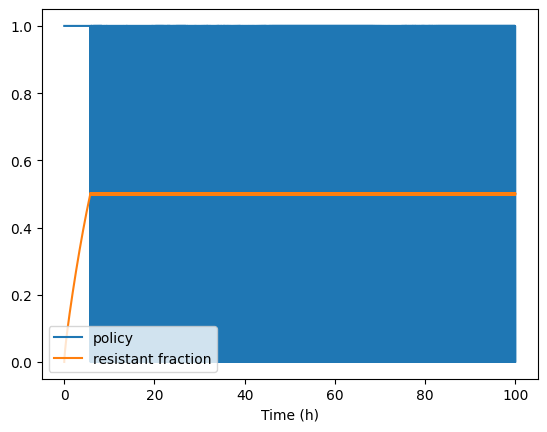

In [36]:
plt.plot(t,bt, label='policy')
plt.plot(t,y[1,:]/tot1, label='resistant fraction')
plt.legend()
# plt.xlim(290,300)
plt.xlabel('Time (h)')
plt.show()

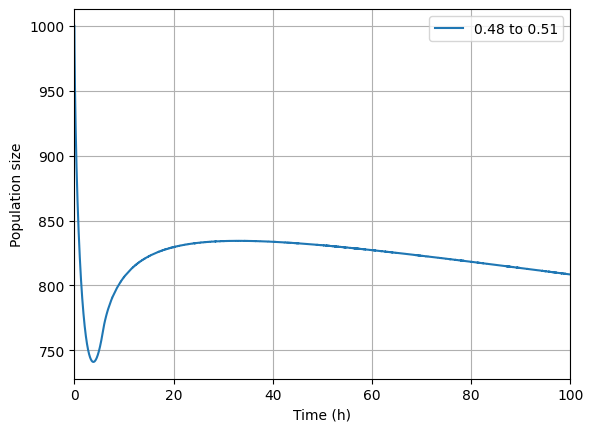

In [37]:
plt.plot(t,tot1.T, label='0.48 to 0.51')
plt.xlabel('Time (h)')
plt.ylabel('Population size')
plt.legend()
plt.xlim(0,100)
# grid lines:
plt.grid()
plt.show()

In [38]:
# Save to numpy file
# time and totals:
data = np.vstack((t, tot1))
np.save(f'hardcoded_data_{alpha_mem}.npy', data)